In [1]:
import jax
# jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from itertools import count
import jax.random as jr
import jax.scipy as jsci
from jax import jit,vmap, lax
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from functools import partial
from utils import *
from plotting_utils import *
from inference_and_sample import *
import task_subspace_LDS



keys = map(jr.PRNGKey, count())

In [2]:
print(jax.devices())

[CudaDevice(id=0)]


In [3]:
D = 50
K1 = 3
K2 = 2
M = 2

S = 250
T = 100

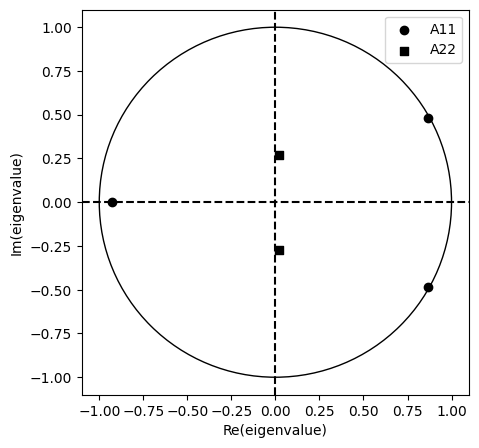

In [4]:
eigs1 = generate_eigenvalues(next(keys), K1, R=1, r=0.8)
eigs2 = generate_eigenvalues(next(keys), K2, R=0.3, r=0.1)

fig, axes = plt.subplots(figsize=(5,5))
plot_eigenvalues(axes, eigs1, eigs2, color='black', label=['A11','A22'], alpha=1)
axes.legend()



In [5]:
LDS = task_subspace_LDS.task_subspace_LDS(D, K1, K2, M)
trueA = LDS.generate_dynamics_matrix(next(keys), eigs1, eigs2)
trueu = LDS.generate_inputs(next(keys), S, T)
trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR = LDS.generate_other_parameters(next(keys), trueA)

In [6]:
# checking that trueA has the desired eigenvalues
eigvals1 = jnp.linalg.eigvals(trueA[:K1,:K1])
eigvals2 = jnp.linalg.eigvals(trueA[K1:,K1:])

print(compare_as_sets(eigvals1, eigs1, tol=1e-12))
print(compare_as_sets(eigvals2, eigs2, tol=1e-12))
print(compare_as_sets(jnp.concatenate([eigvals1, eigvals2]), jnp.linalg.eigvals(trueA), tol=1e-12))


True
True
True


In [7]:
def generate_dynamics_AA(key, eigenvalues, normal=True, distr='normal'):
    '''
    generate dynamics matrix A with real entries that has a given set of eigenvalues (where complex eigs appear in conjugate pairs)

    eigenvectors: np array
        columns are eigenvectors
    '''
    K = eigenvalues.shape[0]

    if K == 1:
        A = jnp.ones((1,1))
        A[0,0] = jnp.real(eigenvalues[0])
    else:
        if compare_as_sets(eigenvalues, jnp.conj(eigenvalues)) == False:
            raise Exception ('Eigenvalues are NOT in conjugate pairs')
        
        idx = jnp.lexsort((jnp.imag(eigenvalues), jnp.real(eigenvalues)))
        eigenvalues = eigenvalues[idx]
        
        D = jnp.zeros((K,K,))
        i = 0
        while i < K:
            if jnp.imag(eigenvalues[i]) == 0:
                D = D.at[i,i].set(jnp.real(eigenvalues[i]))
                i += 1
            elif jnp.real(eigenvalues[i]) == jnp.real(eigenvalues[i+1]) and jnp.imag(eigenvalues[i]) == -jnp.imag(eigenvalues[i+1]): 
                D = D.at[i,i].set(jnp.real(eigenvalues[i]))
                D = D.at[i+1,i+1].set(jnp.real(eigenvalues[i]))
                D = D.at[i,i+1].set(jnp.imag(eigenvalues[i]))
                D = D.at[i+1,i].set(-jnp.imag(eigenvalues[i]))
                i += 2
                
        
        if normal == True:
            S = jr.normal(key, (K, K))
            Q, R = jnp.linalg.qr(S)
            Q = Q @ jnp.diag(jnp.sign(jnp.diag(R)))
            A = Q @ D @ Q.T
        else:
            raise Exception('Non-normal A hasnt been considered yet')
            

In [8]:
# x_single, y_single = generate_latents_and_observations(next(keys), trueu[0], trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR)

In [9]:
# whole sessions generation
keys_batch = jr.split(next(keys), S)
truex, truey = generate_latents_and_observations_batches(keys_batch, trueu, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR)

In [10]:
print(truex.shape)
print(truey.shape)

(250, 100, 5)
(250, 100, 50)


In [11]:
mu, mu_prior, V, V_prior, ll = Kalman_filter_E_step_batches(truey, trueu, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR)
print(mu.shape)
print(ll)

(250, 100, 5)
[-105.32295805  -69.55871433  -33.87200409  -80.57593734  -33.29216498
   32.78917105  -11.55735205  -43.73079626  -28.94888515  -58.59767493
  -26.7083464   -28.5536281   -92.8852561   -63.6994269    24.13650049
  -15.75637631    4.24662933  -32.26835674  -32.02689173  -63.05319924
  -46.49999144   33.26399341 -116.05320715  -42.43923359  -43.02316069
  -89.29253615 -129.41203634  -40.35516132  -50.07673744  -88.65483305
  -32.44548302    3.32052354   93.3585035   -66.36604696  -24.41177359
  -42.24150326  -17.25620091   33.59723757  -84.38466161   -6.919091
  -51.43810737   34.69390165  -42.96486692  -17.73451853  -50.05973296
  -36.81120916   87.37554113   43.19764543  -11.8003539   -31.00887982
 -105.81973109   56.01015165    4.62262697    8.98465187   33.82727866
 -100.58168415   24.13239001  -13.7472846   -58.97961508 -131.89862568
 -116.52712458   29.79841654   -8.16716499   46.20241385 -132.31232175
 -110.38165523  -17.38070107  -30.37165982  -97.74267959  -36.611

In [12]:
jnp.savez('model_to_check.npz', truex=truex, truey=truey, trueu=trueu, trueA=trueA, trueB=trueB, trueQ=trueQ, truemu0=truemu0, trueQ0=trueQ0, trueC=trueC, trued=trued, trueR=trueR)

In [13]:
m, cov, cov_successive = Kalman_smoother_E_step_batches(trueA, mu, mu_prior, V, V_prior)
print(m.shape)

(250, 100, 5)


In [14]:
M1, M1_T, M_next, Y1, Y2, Y_tilde, M_first, M_last, U1_T, U_tilde, U_delta = sufficient_statistics_E_step_batches(trueu, truey, m, cov, cov_successive)

print(M1.shape)
print(M_next.shape)

(250, 5)
(250, 5, 5)


In [15]:
# Per-session stats (each with leading S axis)
sufficient_stats = sufficient_statistics_E_step_batches(trueu, truey, m, cov, cov_successive)

# Sum across sessions for every leaf
stats = tree_map(lambda x: x.sum(axis=0), sufficient_stats)

M1, M1_T, M_next, Y1, Y2, Y_tilde, M_first, M_last, U1_T, U_tilde, U_delta = stats

print(M_first.shape)

(5, 5)


In [16]:
# C = optimize_C_Stiefel(trueC, trued, trueR, M1, M1_T, M_last, Y_tilde, max_iter_C=10, verbosity=0)

In [17]:
# A, B, Q, mu0, Q0, C, d, R = modified_M_step(K1, trueu, truey, trueA, trueB, trueQ , truemu0, trueQ0, trueC, trued, trueR, m, cov, cov_successive, max_iter_C=1, verbosity=0)

In [18]:
# ecll_new, ecll_old, elbo, ll, A, B, Q , mu0, Q0, C, d, R  = LDS.fit_EM(u, true_y, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R, max_iter=10, verbosity=0)

In [19]:
!nvidia-smi

Tue Sep 23 10:44:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  |   00000000:04:00.0 Off |                  N/A |
|  0%   32C    P2             58W /  250W |    8613MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

/home/lc3919/.conda/envs/lds_env/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [20]:
print("jax:", jax.__version__)
print("devices:", jax.devices())
print("default backend:", jax.default_backend())

jax: 0.5.3
devices: [CudaDevice(id=0)]
default backend: gpu


In [21]:
# A, B, Q, mu0, Q0, C, d, R, timing_log = LDS.fit_EM_timed(K1, trueu, truey, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR,max_iter=5, verbosity=0, print_every=1)
# print(timing_log[-1])

In [22]:
A, B, Q, mu0, Q0, C, d, R = LDS.fit_EM(K1, trueu, truey, trueA, trueB, trueQ, truemu0, trueQ0, trueC, trued, trueR, max_iter=200)

In [33]:
print(mse(R,trueR))

5.901870494492173e-07


In [24]:
print(mse(C[:,:K1],trueC[:,:K1]))
print(mse(C[:,K1:],trueC[:,K1:]))
# mu0 has larger error, but still under 0.2
# d has very large error


1.499798424720706e-06
7.65788251749896e-07


In [40]:
def compute_ECLL(self, u, y, A, B, Q, mu0, Q0, C, d, R, m, cov, cov_next):

    S = y.shape[0]
    T = y.shape[1]
    M1, M1_T, M_next, Y1, Y2, Y_tilde, M_first, M_last, U1_T, U_tilde, U_delta = self.compute_auxillary_matrices_M_step(u, y, m, cov, cov_next)
    Q0_inv = np.linalg.inv(Q0)
    Q_inv = np.linalg.inv(Q)
    R_inv = np.linalg.inv(R)

    # first latent terms 
    ecll = - 0.5 * np.trace(Q0_inv @ M_first)
    ecll += np.trace(Q0_inv @ np.outer(np.sum(m[:,0,:], axis=0), mu0))
    ecll += -0.5 *S * np.trace(Q0_inv @ np.outer(mu0,mu0))

    # Q terms 
    ecll += -0.5 * np.trace(Q_inv @ (M1_T - M_first + M_last)) \
            + np.trace(Q_inv @ A @ M_next) \
            - 0.5 * np.trace(A.T @ Q_inv @ A @ M1_T)

    # R terms 
    ecll += -0.5 * np.trace(R_inv @ Y2) \
            + np.trace(R_inv @ C @ Y_tilde) \
            - 0.5 * np.trace(C.T @ R_inv @ C @ (M1_T + M_last))

    # d terms
    ecll += -0.5 * S * T * d.T @ R_inv @ d \
            + np.trace(R_inv @ np.outer(Y1,d)) \
            - np.trace(R_inv @ C @ np.outer(M1,d))

    # B, U terms
    ecll += -0.5 * np.trace(B.T @ Q_inv @ B @ U1_T) \
            + np.trace(B.T @ Q_inv @ U_delta) \
            - np.trace(B.T @ Q_inv @ A @ U_tilde)

    # logdet terms 
    ecll += - 0.5 * (T-1) * S * np.log(np.linalg.det(Q)) - 0.5 * (T-1) * S * Q.shape[0] * np.log(2*np.pi) \
            - 0.5 * T * S * np.log(np.linalg.det(R)) - 0.5 * T * S * R.shape[0] * np.log(2*np.pi) \
        - 0.5 * S * np.log(np.linalg.det(Q0)) - 0.5 * S * Q0.shape[0] * np.log(2*np.pi)

    H = 0.5 * S * T * self.K * np.log(2 * np.pi * np.e)
    for s in range(S):
        sign, logdet = np.linalg.slogdet(cov[s,0])
        H += 0.5 * sign * logdet
        for i in range(1,T):
            aux = cov[s,i] - cov_next[s,i-1].T @ np.linalg.inv(cov[s,i-1]) @ cov_next[s,i-1]
            sign, logdet = np.linalg.slogdet(aux)
            H += 0.5 * sign * logdet
    elbo = ecll + H

    return ecll, elbo

1.5515430237179084e-07
